# NLU - 문장 유사도 계산 (STS)
11팀 조한희 강지호 윤진헌 김예림 김성우 신원지

## Overview


```bash
|-- README.md
|-- data
|   |-- NIKLex_synonym.tsv # Easy Data Agumentation 용
|   |-- STS_backtranslation.csv # train data를 Back translate 한 파일
|   |-- STS_test.csv # klue-sts dev set
|   |-- STS_train.csv # 원본 klue sts + Back Translation으로 증강된 데이터
|   |-- STS_valid.csv 
|   `-- readme.md
|-- data_preprocessing
|   |-- __pycache__
|   |   |-- cleaning.cpython-37.pyc
|   |   |-- eda.cpython-37.pyc
|   |   `-- preprocessing.cpython-37.pyc
|   |-- back_trans.py # Pororo 기반 backtranslation 
|   |-- cleaning.py # Data Cleaing 불용어 제거
|   |-- eda.py # EDA : Synonym Replacement , Random Insertion, Random Swap Random Deletion 수행
|   `-- preprocessing.py # Cleaning, EDA, Back Translation 순차적으로 수행
|-- NLU_STS.ipynb # 시연용 실행 파일
|-- model
|   `-- logging_model.py # hyperparmeter tuning을 위해 수정한 class 파일
|-- model_files # 모델 파일이 저장되는 경로
|   `-- readme.md
`-- sts_dev_set _final.csv # 최종 모델로 생성한 예측값

```

## SetUp

In [ ]:
!git clone https://github.com/seawavve/NLU_STS
%cd NLU_STS

Cloning into 'NLU_STS'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 137 (delta 60), reused 18 (delta 3), pack-reused 0
Receiving objects: 100% (137/137), 5.43 MiB | 3.65 MiB/s, done.
Resolving deltas: 100% (60/60), done.
/content/NLU_STS


In [ ]:
# sentence trainsformer , konlpy wandb 설치
!pip install -U sentence-transformers
!pip install konlpy
!pip install wandb --upgrade

     |████████████████████████████████| 79 kB 4.3 MB/s 
     |████████████████████████████████| 3.8 MB 34.0 MB/s 
     |████████████████████████████████| 1.2 MB 32.5 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 6.5 MB 15.7 MB/s 
     |████████████████████████████████| 895 kB 50.0 MB/s 
     |████████████████████████████████| 596 kB 38.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=777a878a879ce5ed6946ab6234995d2587b6cf1f3b210502f518f94d3a2c7054
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 19.4 MB 8.9 MB/s 
     |████████████████████████████████| 448 kB 50.6 MB/s 
    

In [ ]:
# 전처리 및 util
import os
import sys
import pandas as pd
import numpy as np 
import random
import json
import math
import logging
from sklearn.model_selection import train_test_split
from datetime import datetime
from sentence_transformers.readers import InputExample

# 모델링
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, random_split
from sentence_transformers import models, LoggingHandler, util ,losses, SentenceTransformer

import wandb

# wandb log를 위해 수정한 SentenceTransFormer , EmbeddingSimilarityEvaluator
from model.logging_model import * 

## Load Processed & Augumented Data

전처리용으로 만든 data_preprocessing Class를 불러와 Data Cleaing,  Easy Data Augmentation,  BackTranslation 을 순차적으로 실행합니다.

In [ ]:
import sys
sys.path.append('./data_preprocessing')
import preprocessing as pp # 데이터 전처리용 Util

path = './data/'    
n = 2
_pp = pp.data_preprosessing(path, n) 
_train, _test = _pp.load_origin_file()
_train, _valid = train_test_split(_train, test_size=0.1, random_state=42) 
train, valid, test = _pp.load_all(_train, _valid, _test) 

Length of original DF : 11661
Length of original dev : 519

************** cleaning : train **************


Cleaning start


column name : sentence1

Remove chiness charecter start


100%|██████████| 10494/10494 [00:00<00:00, 376737.76it/s]


Remove english start


100%|██████████| 10494/10494 [00:00<00:00, 472345.32it/s]


Remove special charecter start


100%|██████████| 10494/10494 [00:00<00:00, 136364.42it/s]


Remove repeated spacing start


100%|██████████| 10494/10494 [00:00<00:00, 209405.90it/s]


Remove repeated spacing start


100%|██████████| 10494/10494 [00:00<00:00, 96342.48it/s] 



column name : sentence2

Remove chiness charecter start


100%|██████████| 10494/10494 [00:00<00:00, 255804.64it/s]


Remove english start


100%|██████████| 10494/10494 [00:00<00:00, 238975.72it/s]


Remove special charecter start


100%|██████████| 10494/10494 [00:00<00:00, 106204.90it/s]


Remove repeated spacing start


100%|██████████| 10494/10494 [00:00<00:00, 195507.64it/s]


Remove repeated spacing start


100%|██████████| 10494/10494 [00:00<00:00, 124851.51it/s]



Cleaning start


column name : sentence1

Remove chiness charecter start


100%|██████████| 1167/1167 [00:00<00:00, 266062.55it/s]


Remove english start


100%|██████████| 1167/1167 [00:00<00:00, 478189.99it/s]


Remove special charecter start


100%|██████████| 1167/1167 [00:00<00:00, 204998.65it/s]


Remove repeated spacing start


100%|██████████| 1167/1167 [00:00<00:00, 401307.93it/s]


Remove repeated spacing start


100%|██████████| 1167/1167 [00:00<00:00, 177262.62it/s]



column name : sentence2

Remove chiness charecter start


100%|██████████| 1167/1167 [00:00<00:00, 279604.29it/s]


Remove english start


100%|██████████| 1167/1167 [00:00<00:00, 284314.17it/s]


Remove special charecter start


100%|██████████| 1167/1167 [00:00<00:00, 95036.36it/s]


Remove repeated spacing start


100%|██████████| 1167/1167 [00:00<00:00, 203025.96it/s]


Remove repeated spacing start


100%|██████████| 1167/1167 [00:00<00:00, 214203.00it/s]



Cleaning start


column name : sentence1

Remove chiness charecter start


100%|██████████| 519/519 [00:00<00:00, 299140.27it/s]


Remove english start


100%|██████████| 519/519 [00:00<00:00, 112924.41it/s]


Remove special charecter start


100%|██████████| 519/519 [00:00<00:00, 255648.12it/s]


Remove repeated spacing start


100%|██████████| 519/519 [00:00<00:00, 378055.54it/s]


Remove repeated spacing start


100%|██████████| 519/519 [00:00<00:00, 145306.97it/s]



column name : sentence2

Remove chiness charecter start


100%|██████████| 519/519 [00:00<00:00, 242951.31it/s]


Remove english start


100%|██████████| 519/519 [00:00<00:00, 213227.91it/s]


Remove special charecter start


100%|██████████| 519/519 [00:00<00:00, 114830.60it/s]


Remove repeated spacing start


100%|██████████| 519/519 [00:00<00:00, 187901.92it/s]


Remove repeated spacing start


100%|██████████| 519/519 [00:00<00:00, 108451.76it/s]



************** cleaned train length : 10494, valid length : 1167, test length : 519 **************


************** back translate : train **************


Cleaning start


column name : sentence1

Remove chiness charecter start


100%|██████████| 10494/10494 [00:00<00:00, 482594.44it/s]


Remove english start


100%|██████████| 10494/10494 [00:00<00:00, 431608.73it/s]


Remove special charecter start


100%|██████████| 10494/10494 [00:00<00:00, 252099.31it/s]


Remove repeated spacing start


100%|██████████| 10494/10494 [00:00<00:00, 369213.31it/s]


Remove repeated spacing start


100%|██████████| 10494/10494 [00:00<00:00, 193236.51it/s]



column name : sentence2

Remove chiness charecter start


100%|██████████| 10494/10494 [00:00<00:00, 364921.66it/s]


Remove english start


100%|██████████| 10494/10494 [00:00<00:00, 405683.40it/s]


Remove special charecter start


100%|██████████| 10494/10494 [00:00<00:00, 268874.51it/s]


Remove repeated spacing start


100%|██████████| 10494/10494 [00:00<00:00, 401146.76it/s]


Remove repeated spacing start


100%|██████████| 10494/10494 [00:00<00:00, 220306.45it/s]



************** back translate train length : 10489 **************


************** data augmentation : train **************


column name : sentence1

column name : sentence2

Cleaning start


column name : sentence1

Remove chiness charecter start


100%|██████████| 41976/41976 [00:00<00:00, 522222.80it/s]


Remove english start


100%|██████████| 41976/41976 [00:00<00:00, 528428.15it/s]


Remove special charecter start


100%|██████████| 41976/41976 [00:00<00:00, 255582.21it/s]


Remove repeated spacing start


100%|██████████| 41976/41976 [00:00<00:00, 388569.59it/s]


Remove repeated spacing start


100%|██████████| 41976/41976 [00:00<00:00, 215108.02it/s]



column name : sentence2

Remove chiness charecter start


100%|██████████| 41976/41976 [00:00<00:00, 509551.12it/s]


Remove english start


100%|██████████| 41976/41976 [00:00<00:00, 532605.20it/s]


Remove special charecter start


100%|██████████| 41976/41976 [00:00<00:00, 259736.20it/s]


Remove repeated spacing start


100%|██████████| 41976/41976 [00:00<00:00, 388775.52it/s]


Remove repeated spacing start


100%|██████████| 41976/41976 [00:00<00:00, 227612.52it/s]



************** data augmentation train length : 41275 **************


************** concat : train **************


************** concat train length : 60735 **************


************** saving files : train, valid, test **************


************** train length : 60735, valid length : 1167, test length : 519 **************



data preprocessing.py에서 진행하는 전처리 과정중 Pororo를 활용한 Back Translation의 실행시간이 오래걸리기에 본 파일에서는 Back Translation을 미리 완료하고 저장된 data를 불러옵니다.

In [ ]:
def str_to_json(x):
    """
    read_csv에서 string 형태로 읽어오는 label을 dictionary로 변환
    """
    x = x.replace("'", '"')
    x = json.loads(x)

    return x

train_path = "./data/STS_train.csv"
valid_path = "./data/STS_valid.csv"
test_path = "./data/STS_test.csv"
train = pd.read_csv(train_path)
valid = pd.read_csv(valid_path)
test = pd.read_csv(test_path)

train['labels'] = train['labels'].apply(str_to_json)
valid['labels'] = valid['labels'].apply(str_to_json)
test['labels'] = test['labels'].apply(str_to_json)

print(f'Length of Train : {len(train)}') 
print(f"Length of Valid : {len(valid)}")
print(f'Length of Test : {len(test)}') 

Length of Train : 20983
Length of Valid : 1167
Length of Test : 519


In [ ]:
# 최종 데이터 head
display(train.head)
display(valid.head)
display(test.head)

<bound method NDFrame.head of                                                sentence1  \
0          다만 1월달에 공사소리때문에 시끄러웠다는 후기를봤는데 여전히 공사를 하는듯합니다.   
1                            경쟁력 위원회는 이날 6건의 협력사업도 승인했다.   
2                       다만 공용 거실이 없어 2명이 지내기에는 좁은 듯 합니다.   
3                             여행기간 내내 잠을 잘 자서 힐링이 잘 되었어요   
4                      대신 제일 꼭대기층이어서 캐리어 가져가기 좀 힘들긴 합니다.   
...                                                  ...   
20978                  그러나 이는 구글 지도에서 대중교통이 나오는 지역이 아니다.   
20979                          인테리어에서도 주인의 신중한 마음이 드러났다.   
20980                         호스트와 침대와 연락이 닿았다는 사실이 좋았다.   
20981                                  위치와 시설 호스트가 완벽했다.   
20982  올해부터는 부산 대구 남구 인천 연수구 등 5개 지역의 문화예능사업이 통합지원을 받는다.   

                                               sentence2  \
0                   다만 1인실용이기 때문에 다소 좁지만 혼자서 이용하긴 충분합니다.   
1                                결함신고와 리콜현황의 통계기능도 강화했다.   
2                하지만 공공 거실이 없어서 두 사람이 머물기에는 너무 작은 것 같아요.   
3        

<bound method NDFrame.head of                                               sentence1  \
0                                    우산 두고 오지 않았으면 좋겠어.   
1                                 다만 밤에 돌아다니기엔 조금 무섭습니다   
2     중소벤처기업부 등 17개 부처가 마련한 방안은 코로나19 피해기업 지원과 농업 신산...   
3      2020 부산국제광고제 와 관련된 더욱 자세한 내용은 부산국제광고제 누리집 .. ...   
4                          모던한 느낌으로 모든 사람들이 좋아할만한 집입니다.   
...                                                 ...   
1162                     치과를 예약하고 싶은데 다음주 중 되는 시간이 얹에요    
1163  국토부는 고령가구에 대해서는 2025년까지 무장애 설계가 적용된 공공임대 8만호를 ...   
1164                             친구들과 지내기 정말 좋은 장소였습니다.   
1165                   믹서기 말고 가스레인지로 요리할 수 있도록 협조 바랍니다.   
1166                                    냉장고 문 열려고 시도하지마   

                                              sentence2  \
0                                     우산 두고 오지 않기로 했잖아    
1                                     밤에 돌아다니기가 좀 무서워요.   
2             문체부 등 각 부처 지원 사업 안내 코로나19 피해 상담 등 통합창구 개설   
3     부산국제광고제에 대한 자세한 내용은

<bound method NDFrame.head of                                              sentence1  \
0                             무엇보다도 호스트분들이 너무 친절하셨습니다.   
1                               주요 관광지 모두 걸어서 이동가능합니다.   
2    학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...   
3                             다만 도로와 인접해서 거리의 소음이 들려요.   
4                  형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.   
..                                                 ...   
514     문체부는 이를 연차적으로 확대 시행해 학교운동부와 스포츠클럽 간의 연계를 강화한다.   
515                        일단 정확한 정보와 빠른 답변이 정말 좋았습니다.   
516                         게스트에 대한 배려가 묻어나는 시설들이었습니다.   
517                          밤하늘을 배경으로 비대면 드론쇼 도 펼쳐진다.   
518                      여느 포르투갈의 비앤비와 같이 엘리베이터는 없습니다.   

                                             sentence2  \
0                               무엇보다도 호스트들은 매우 친절했습니다.   
1                          위치는 피렌체 중심가까지 걸어서 이동 가능합니다.   
2    영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...   
3                    하지만 길과 가깝기 때문에 거리의 소

모델에 Input으로 사용하기 위한 Custom Dataset 을 생성합니다.


In [ ]:
class STSDataset(Dataset):
  def __init__(self, df:pd.DataFrame):
      self.texts = list(zip(df['sentence1'].tolist(),df['sentence2'].tolist()))
      self.texts = [list(x) for x in self.texts]
      self.labels = df['normalized'].tolist()
      self.input_examples = self.make_sts_input(self.texts,self.labels)

  def __len__(self):
      return len(self.input_examples)

  def __getitem__(self, index):
      return self.input_examples[index]

  def make_sts_input(self,texts,labels):
      input_examples =[]
      for text,label in zip(texts,labels):
          input = InputExample(texts = text,label = label)
          input_examples.append(input)

      return input_examples 
       

In [ ]:
train_dataset = STSDataset(train)
valid_dataset = STSDataset(valid)
test_set = STSDataset(test)

In [ ]:
print(f"Train Dataset len: {len(train_dataset)}")
print(f"Train Dataset 1st element: {train_dataset[0]}\n")

print(f"Valid Dataset len: {len(valid_dataset)}")
print(f"Valid Dataset 1st element: {valid_dataset[0]}\n")

print(f"Test Dataset len: {len(test_set)}")
print(f"Test Dataset 1st element:{test_set[0]}")

Train Dataset len: 20983
Train Dataset 1st element: <InputExample> label: 0.04, texts: 다만 1월달에 공사소리때문에 시끄러웠다는 후기를봤는데 여전히 공사를 하는듯합니다.; 다만 1인실용이기 때문에 다소 좁지만 혼자서 이용하긴 충분합니다.

Valid Dataset len: 1167
Valid Dataset 1st element: <InputExample> label: 0.6, texts: 우산 두고 오지 않았으면 좋겠어.; 우산 두고 오지 않기로 했잖아 

Test Dataset len: 519
Test Dataset 1st element:<InputExample> label: 0.98, texts: 무엇보다도 호스트분들이 너무 친절하셨습니다.; 무엇보다도 호스트들은 매우 친절했습니다.


In [33]:
def ret_dataloader(train_dataset,valid_dataset,batch_size : int ):
    """
    학습 과정에 사용하기 위한 train dataloader , evaluator를 반환하는 util 함수
    """
    _batch_size = batch_size
    train_dataloader = DataLoader(train_dataset,shuffle=True , batch_size = _batch_size)
    valid_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(valid_dataset,name="valid_set")
    
    return train_dataloader,valid_evaluator

## Model

In [ ]:
model_path = './model'
sys.path.append(model_path)

### Parameter Tuning

TensorBoard와 WandB 중 시각화에 조견에 따른 비교 측면에서 보다 팀원들이 보다 유리하다고 판단한 WandB를 사용하였습니다.

In [ ]:
import wandb
wandb.login()

%env WANDB_WATCH = all # 모든 파라미터와 gradient log
#%env WANDB_ENTITY = wanted_sts # team name
#%env WANDB_PROJECT = STS # project name

project_name = "NLU_STS"
wandb.init(project=project_name)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wanted_sts (use `wandb login --relogin` to force relogin)


env: WANDB_WATCH=all # 모든 파라미터와 gradient log


In [34]:
# hyperparameter 설정을 위한 sweep value config

sweep_config = {
    'method': 'random'
    }

early_terminate = {
    'type': 'hyperband',
    'max_iter': 1000
}

parameters_dict = {
    # Optimizer: adamw
    'epochs' : {
        'value': 4
    },
    'optimizer_params': {
        'values' : [
                {'lr':1e-4},
                #{'lr':3e-4}, 테스트용으로 진행한 파라미터 튜닝 과정에서 해당 값은 모델 성능에 악영향을 미치는 것으로 나타나 제외하였습니다.
                {'lr':5e-5}
                ]
    },
    'weight_decay':{
        'distribution': 'uniform',
        'min': 0.01,
        'max': 0.1
    },
    'batch_size' :{
        'values': [16,32,64]
      }
    }

sweep_config['parameters'] = parameters_dict

In [35]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'parameters': {'batch_size': {'values': [16, 32, 64]},
                'epochs': {'value': 4},
                'optimizer_params': {'values': [{'lr': 0.0001}, {'lr': 5e-05}]},
                'weight_decay': {'distribution': 'uniform',
                                 'max': 0.1,
                                 'min': 0.01}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project=project_name)

Create sweep with ID: jg66teq9
Sweep URL: https://wandb.ai/wanted_sts/NLU_STS/sweeps/jg66teq9


In [ ]:

def ret_model(model_name):
    """
    학습과정에 사용되는 모델 생성용 함수
    """
    # pretrained embedding model을  가져옴
    embedding_model = models.Transformer(
            model_name_or_path=model_name, 
            max_seq_length=256,
            do_lower_case=False
            )

    # 문장을 고정된 크기의의 임베딩으로 변환
    pooling_model = models.Pooling(
        embedding_model.get_word_embedding_dimension(), 
        pooling_mode_mean_tokens=True,
        pooling_mode_cls_token=False,
        pooling_mode_max_tokens=False,)
    
    model = SentenceTransformer(modules=[embedding_model, pooling_model])

    return model


In [ ]:
from pytz import timezone
from datetime import datetime

def set_model_path(save_path,model_name:str):
    """
    모델 저장 path 설정용 help 함수
    """
    today = datetime.now(timezone('Asia/Seoul'))
    save_path = save_path
    model_save_path = save_path+'/training_sts-'+model_name.replace("/", "-")+'-'+today.strftime("%Y-%m-%d_%H-%M-%S")

    return model_save_path

In [ ]:
model_name = "Huffon/sentence-klue-roberta-base" # pretrained model
save_path = './model_files' # 학습된 모델 저장경로

def train(config=None,model = None):
    """
    모델학습 밒 하이퍼파리미터 튜닝
    """
    with wandb.init(config=config):
        config = wandb.config # wandb에 저장해둔 parameter를 가져옴 / config.파라미터명으로 wandb에서 튜닝한 파라미터로 모델이 학습됨.
        model = ret_model(model_name)

        # 코사인 유사도 기반 MSEloss 설정
        train_loss = losses.CosineSimilarityLoss(model=model) 
        model_save_path = set_model_path(save_path,model_name=model_name)

        # set batch_size
        train_batch_size = config.batch_size

        # 
        train_dataloader , valid_evaluator = ret_dataloader(train_dataset,valid_dataset,batch_size = config.batch_size)
        print('train data loaded')
        
        # warmup step으로 train data의 10% 사용
        warmup_steps = math.ceil(len(train_dataset) * config.epochs / train_batch_size * 0.1) 

        model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            evaluator=valid_evaluator, # valid로 평가
            epochs=config.epochs,
            optimizer_params = config.optimizer_params,
            weight_decay = config.weight_decay,
            evaluation_steps=int(len(train_dataloader)*0.1),
            warmup_steps = warmup_steps,
            output_path= model_save_path,
            show_progress_bar = True
        )
   

wandb를 통해 count 수만큼 모델을 생성해 학습하고 wandb.config에서 랜덤으로 생성된 hyperparmeter 값에 따른 loss를 기록합니다.

In [ ]:
wandb.agent(sweep_id, train, count=1) # 본 파일에서는 1개의 count를 줘서 1개의 모델을 생성하였습니다.

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: gfxacl22 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 4
wandb: 	optimizer_params: {'lr': 0.0001}
wandb: 	weight_decay: 0.09123580692439642


Downloading:   0%|          | 0.00/744 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

train data loaded


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1312 [00:00<?, ?it/s]


################ F1 Score 계산 ################
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       596
           1       0.93      1.00      0.96       571

    accuracy                           0.96      1167
   macro avg       0.96      0.96      0.96      1167
weighted avg       0.96      0.96      0.96      1167


################ F1 Score 계산 ################
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       596
           1       0.91      0.99      0.95       571

    accuracy                           0.95      1167
   macro avg       0.95      0.95      0.95      1167
weighted avg       0.95      0.95      0.95      1167


################ F1 Score 계산 ################
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       596
           1       0.91      0.98      0.95       571

    accuracy                           0.

Iteration:   0%|          | 0/1312 [00:00<?, ?it/s]


################ F1 Score 계산 ################
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       596
           1       0.91      0.97      0.94       571

    accuracy                           0.94      1167
   macro avg       0.94      0.94      0.94      1167
weighted avg       0.94      0.94      0.94      1167


################ F1 Score 계산 ################
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       596
           1       0.91      0.95      0.93       571

    accuracy                           0.93      1167
   macro avg       0.93      0.93      0.93      1167
weighted avg       0.93      0.93      0.93      1167


################ F1 Score 계산 ################
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       596
           1       0.90      0.97      0.93       571

    accuracy                           0.

Iteration:   0%|          | 0/1312 [00:00<?, ?it/s]


################ F1 Score 계산 ################
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       596
           1       0.91      0.96      0.94       571

    accuracy                           0.93      1167
   macro avg       0.94      0.94      0.93      1167
weighted avg       0.94      0.93      0.93      1167


################ F1 Score 계산 ################
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       596
           1       0.93      0.96      0.94       571

    accuracy                           0.94      1167
   macro avg       0.94      0.94      0.94      1167
weighted avg       0.94      0.94      0.94      1167


################ F1 Score 계산 ################
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       596
           1       0.92      0.98      0.95       571

    accuracy                           0.

Iteration:   0%|          | 0/1312 [00:00<?, ?it/s]


################ F1 Score 계산 ################
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       596
           1       0.93      0.98      0.95       571

    accuracy                           0.95      1167
   macro avg       0.95      0.95      0.95      1167
weighted avg       0.95      0.95      0.95      1167


################ F1 Score 계산 ################
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       596
           1       0.93      0.98      0.95       571

    accuracy                           0.95      1167
   macro avg       0.96      0.96      0.95      1167
weighted avg       0.96      0.95      0.95      1167


################ F1 Score 계산 ################
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       596
           1       0.93      0.98      0.95       571

    accuracy                           0.

f1,█▇▆▄▄▁▄▂▂▃▅▄▅▅▅▆▅▅▅▆▅▆▆▅▆▅▇▆▇▇▇▇▇█▇▇▇▇▇▇
loss,▃▂▄█▃▇▃▄▄▆▃▂▃▅▁▃▃▂▂▂▂▂▂▂▁▂▃▂▁▂▁▁▁▂▁▁▁▁▁▁
f1,0.95311
loss,0.00268


### Find best model
- F1 score
- Pearson's r
- wandb로 훈련시킨 모델을 dev set으로 하나씩 평가하며 각 모델의 성능을 평가하고, 최종 모델 고르기.
    - 모델의 크기가 너무 커서 github에 업로드가 안되므로 구글 드라이브에서 불러와야 합니다.
    - 공유 드라이브에서 샘플 모델을 제공합니다.
이 [사이트](https://drive.google.com/drive/folders/1B6WMGbNGVoEBfzA4854H0MbmKqAGzAkF?usp=sharing)에서 `드라이브 바로가기`를 눌러 내 드라이브에 저장해 사용합니다.

    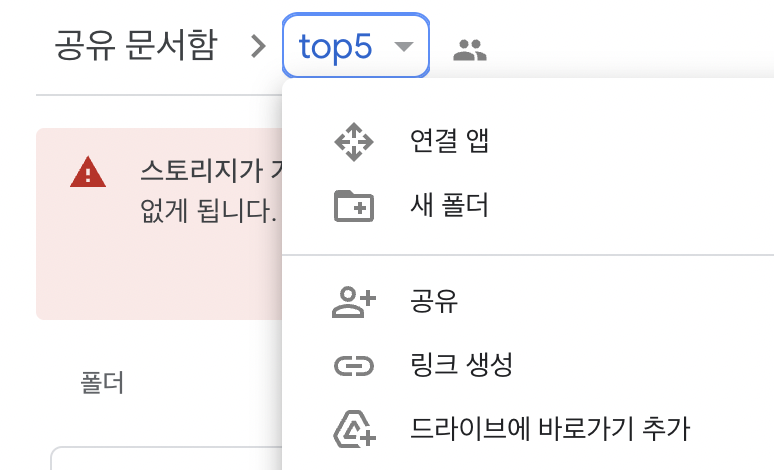


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances, paired_manhattan_distances
from scipy.stats import pearsonr

In [ ]:
# 가장 좋은 성능을 추출하기 위해 위에서 훈련했던 모델 가져오기

path = '/content/NLU_STS/model_files/'
model_saved = [path+x for x in os.listdir(path) if x.startswith("training")]
print('model:', model_saved)

# dev set 가져오기
test = pd.read_csv('./data/STS_test.csv')
sentence1 = []
sentence2 = []
labels = []

for i in range(len(test)):
    sentence1.append(test['sentence1'][i])
    sentence2.append(test['sentence2'][i])
    labels.append(test['normalized'][i])

print(f'\ndev set len : sentence1- {len(sentence1)}, sentence2 - {len(sentence2)}, labels - {len(labels)}')

model: ['/content/NLU_STS/model_files/training_sts-Huffon-sentence-klue-roberta-base-2022-03-24_12-07-56']

dev set len : sentence1- 519, sentence2 - 519, labels - 519


In [ ]:
# 각 모델별 dev set score 계산하기

for model in model_saved:
    print(f'\n\n######### model: {model} #########')
    model = SentenceTransformer(model)

    corpus_embeddings = model.encode(sentence1, convert_to_tensor=True) # senetence1 유사도
    query_embeddings = model.encode(sentence2, convert_to_tensor=True) # sentence2 유사도

    print(f'\n------------- f1 score -------------')
    def cosine_similarity_manual(x, y, small_number=1e-8): # sentence1과 sentence2의 임베딩값으로 유사도 계산
        result =  torch.dot(x, y) / (torch.linalg.norm(x) * torch.linalg.norm(y) + small_number)
        return result

    test_scores = []
    for i in range(len(sentence1)):
        score = cosine_similarity_manual(corpus_embeddings[i],query_embeddings[i])
        score=score.cpu().detach().numpy()
        test_scores.append(score)

    test_scores = np.array(test_scores) # 모델 예측값
    y_pred = np.where(test_scores>=0.6, 1, 0) # klue에서 3.0을 기준으로 binary label을 만들었기에, normalize 기준 threshold: 0.6
    labels = np.array(labels)
    y_label = np.where(labels >= 0.6, 1, 0)

    print(classification_report(y_label, y_pred))

    print(f'\n------------- Pearson Similarity -------------')  # Pearson 기반 유사도 출력
    corpus_embeddings = corpus_embeddings.cpu().detach().numpy()
    query_embeddings = query_embeddings.cpu().detach().numpy()

    cosine_scores = 1 - (paired_cosine_distances(corpus_embeddings, query_embeddings))
    manhattan_distances = -paired_manhattan_distances(corpus_embeddings, query_embeddings)
    euclidean_distances = -paired_euclidean_distances(corpus_embeddings, query_embeddings)
    dot_products = [np.dot(emb1, emb2) for emb1, emb2 in zip(corpus_embeddings, query_embeddings)]


    eval_pearson_cosine, _ = pearsonr(labels, cosine_scores)
    eval_pearson_manhattan, _ = pearsonr(labels, manhattan_distances)
    eval_pearson_euclidean, _ = pearsonr(labels, euclidean_distances)
    eval_pearson_dot, _ = pearsonr(labels, dot_products)

    print("Cosine-Similarity :\tPearson: {:.4f}".format(
        eval_pearson_cosine))
    print("Manhattan-Distance:\tPearson: {:.4f}".format(
        eval_pearson_manhattan))
    print("Euclidean-Distance:\tPearson: {:.4f}".format(
        eval_pearson_euclidean))
    print("Dot-Product-Similarity:\tPearson: {:.4f}".format(
        eval_pearson_dot))



######### model: /content/NLU_STS/model_files/training_sts-Huffon-sentence-klue-roberta-base-2022-03-24_12-07-56 #########

------------- f1 score -------------
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       299
           1       0.73      0.98      0.84       220

    accuracy                           0.84       519
   macro avg       0.86      0.86      0.84       519
weighted avg       0.87      0.84      0.84       519


------------- Pearson Similarity -------------
Cosine-Similarity :	Pearson: 0.8702
Manhattan-Distance:	Pearson: 0.8755
Euclidean-Distance:	Pearson: 0.8760
Dot-Product-Similarity:	Pearson: 0.8577


## Serving
[해당 Repository](https://github.com/seawavve/STS_serving)를 참고 바랍니다.